Using the same method of calculation from previous scoring results in the current season, I am going to project the odds of the score going over or under various goal numbers.

We begin by scraping the home and away tables from UnderStat using our webscraper

In [2]:
import sys
sys.path.append('../scraper')

from epl_table_scraper import WebScraper

# Retrieve 'Home' table
scraper = WebScraper()
scraper.load_page()
scraper.click_element("home-away2")
home_df = scraper.scrape_table()

scraper.close()

# Retrieve 'Away' table
scraper = WebScraper()
scraper.load_page()
scraper.click_element("home-away3")
away_df = scraper.scrape_table()

scraper.close()

Error sending stats to Plausible: error sending request for url (https://plausible.io/api/event)


scraper is locating element... check
element located:  <selenium.webdriver.remote.webelement.WebElement (session="ed4698bf45afd4d77858af67256b0a58", element="f.B54CF8522F5E72F65D7B3CF93882F828.d.9A5F47995ABD3925AC3A838DE483F939.e.33")>
element html:  <input id="home-away2" type="radio" name="home-away" value="h">
clicked the button
checking table update...
confirmed table updated successfully
found table
closing driver...
driver closed
scraper is locating element... check
element located:  <selenium.webdriver.remote.webelement.WebElement (session="262057372608317e1c704c4cd1e4dc7b", element="f.7E2D50BC9FC4916F705CE72AC711AFAE.d.5AE54E04FD94763F45FA3CCD6D9148A0.e.30")>
element html:  <input id="home-away3" type="radio" name="home-away" value="a">
clicked the button
checking table update...
confirmed table updated successfully
found table
closing driver...
driver closed


As before, we will clean these tables up for easier processing.

In [3]:
import pandas as pd

# drop unneeded columns
home_df_cln = home_df.drop(
    columns = [
        'W',
        'D',
        'L',
        'PTS',
        'xG',
        'xGA',
        'xPTS',
    ]
)

away_df_cln = away_df.drop(
    columns = [
        'W',
        'D',
        'L',
        'PTS',
        'xG',
        'xGA',
        'xPTS',
    ]
)

# convert to numeric values
columns_to_clean = ['M', 'G', 'GA']
home_df_cln[columns_to_clean] = home_df_cln[columns_to_clean].apply(
    pd.to_numeric,
    errors='coerce'
)

away_df_cln[columns_to_clean] = away_df_cln[columns_to_clean].apply(
    pd.to_numeric,
    errors='coerce'
)


# calculate gpm_scored and gpm_conceded
home_df_cln["gpm_scored"] = home_df_cln["G"] / home_df_cln["M"]
home_df_cln["gpm_conceded"] = home_df_cln["GA"] / home_df_cln["M"]
print("\n======================   ~ home_df cleaned ~   =====================\n\n", home_df_cln)

away_df_cln["gpm_scored"] = away_df_cln["G"] / away_df_cln["M"]
away_df_cln["gpm_conceded"] = away_df_cln["GA"] / away_df_cln["M"]
print("\n\n======================   ~ away_df cleaned ~   =====================\n\n", away_df_cln)


======================   ~ home_df cleaned ~   =====================

      №                     Team  M   G  GA  gpm_scored  gpm_conceded
0    1                Brentford  8  26  14    3.250000      1.750000
1    2                Liverpool  7  13   3    1.857143      0.428571
2    3                  Arsenal  7  17   6    2.428571      0.857143
3    4          Manchester City  7  15  10    2.142857      1.428571
4    5              Aston Villa  8  13   9    1.625000      1.125000
5    6                   Fulham  8  14  13    1.750000      1.625000
6    7                Tottenham  8  20  11    2.500000      1.375000
7    8              Bournemouth  7  10   6    1.428571      0.857143
8    9                 Brighton  7  12   9    1.714286      1.285714
9   10        Manchester United  8  13  11    1.625000      1.375000
10  11                  Chelsea  7  12   8    1.714286      1.142857
11  12        Nottingham Forest  7   8   6    1.142857      0.857143
12  13         Newcastle United

again, we generate projected goals. We are looking at EVERTON vs. WOLVERHAMPTON WANDERERS because, based on our model, we have seen that a Wolves win is undervalued by our bookmaker. I am suspicious of this because of Wolves poor performance so far in this season. There are two things to make of this:

1. Wolves are a risky pick as a winner because they are not winning a lot. They are conceding 2nd most in the league at the moment as the away side.
2. Everton is having trouble finishing at home and are conceding around the average

I believe there is a good likelihood of Wolves winning and I think this match deserves some further inspection and has potential to be a highscoring affair. Wolves will have something to play for and may see this as a winnable match due to Everton's relative poor performance this season as well. Do they come out swinging? What can my model tell me about the potential total goals scored in this matchup? Let's take a look.

In [ ]:
# 1. define home and away sides
home_side, away_side = "West Ham", "Wolverhampton Wanderers"

# 2. grab their gpm_scored and gpm_conceded
home_side_gpm_scored = home_df_cln.loc[
    home_df_cln["Team"] == home_side,
    "gpm_scored"
].values[0]

home_side_gpm_conceded = home_df_cln.loc[
    home_df_cln["Team"] == home_side,
    "gpm_conceded"
].values[0]

print(home_side_gpm_scored, home_side_gpm_conceded)

away_side_gpm_scored = away_df_cln.loc[
    away_df_cln["Team"] == away_side,
    "gpm_scored"
].values[0]

away_side_gpm_conceded = away_df_cln.loc[
    away_df_cln["Team"] == away_side,
    "gpm_conceded"
].values[0]

print(away_side_gpm_scored, away_side_gpm_conceded)

# 3.
epl_home_avg_gpm_scored = round(sum(home_df_cln["gpm_scored"].values) / 20, 2)
epl_home_avg_gpm_conceded = round(sum(home_df_cln["gpm_conceded"].values) / 20, 2)
print(epl_home_avg_gpm_scored, epl_home_avg_gpm_conceded)

# 4. create a ratio (attack and defense rating) of their gpm to the league average gpm
home_attack_rating = home_side_gpm_scored / epl_home_avg_gpm_scored
away_defense_rating = away_side_gpm_conceded / epl_home_avg_gpm_scored
away_attack_rating = away_side_gpm_scored / epl_home_avg_gpm_conceded
home_defense_rating = home_side_gpm_conceded / epl_home_avg_gpm_conceded

print(home_attack_rating, away_defense_rating, away_attack_rating, home_defense_rating)

# home projected goals
home_projected_goals = home_attack_rating * away_defense_rating * epl_home_avg_gpm_scored
# away projected goals
away_projected_goals = away_attack_rating * home_defense_rating * epl_home_avg_gpm_conceded
print("\n ================== projected_goals ==================== \n")
print("HOME projected goals:", home_projected_goals)
print("AWAY projected goals: ", away_projected_goals)

1.4285714285714286 2.142857142857143
1.5714285714285714 2.5714285714285716
1.62 1.38
0.8818342151675485 1.5873015873015872 1.1387163561076605 1.5527950310559007

 ================== projected_goals ==================== 

HOME projected goals: 2.2675736961451247
AWAY projected goals:  2.440106477373558


and again we generate a table of the exact score probabilities

In [6]:
from scipy.stats import poisson
import numpy as np
# Poisson probability for home team goals 0 - 8
home_score_prob = []
away_score_prob = []
for i in range(9):
    prob = poisson.pmf(i, home_projected_goals)
    home_score_prob.append(prob)
for i in range(9):
    prob = poisson.pmf(i, away_projected_goals)
    away_score_prob.append(prob)

home_score_prob = np.array(home_score_prob)
away_score_prob = np.array(away_score_prob)
# print(home_score_prob)
# print(away_score_prob)

exact_score_prob = np.outer(away_score_prob, home_score_prob)
print(f"{home_side} v. {away_side}", exact_score_prob)

West Ham v. Wolverhampton Wanderers [[9.02569135e-03 2.04664203e-02 2.32045582e-02 1.75393486e-02
  9.94294137e-03 4.50927046e-03 1.70418385e-03 5.52051781e-04
  1.56477262e-04]
 [2.20236479e-02 4.99402447e-02 5.66215927e-02 4.27978781e-02
  2.42618356e-02 1.10031001e-02 4.15839005e-03 1.34706513e-03
  3.81821181e-04]
 [2.68700230e-02 6.09297573e-02 6.90813575e-02 5.22156897e-02
  2.96007311e-02 1.34243679e-02 5.07345724e-03 1.64349117e-03
  4.65842169e-04]
 [2.18552390e-02 4.95583652e-02 5.61886227e-02 4.24706143e-02
  2.40763119e-02 1.09189623e-02 4.12659196e-03 1.33676448e-03
  3.78901498e-04]
 [1.33322776e-02 3.02319220e-02 3.42765555e-02 2.59082052e-02
  1.46871912e-02 6.66085768e-03 2.51733094e-03 8.15461919e-04
  2.31140000e-04]
 [6.50643538e-03 1.47538217e-02 1.67276890e-02 1.26437559e-02
  7.16766206e-03 3.25064039e-03 1.22851111e-03 3.97962782e-04
  1.12801242e-04]
 [2.64606585e-03 6.00014933e-03 6.80289039e-03 5.14201844e-03
  2.91497644e-03 1.32198478e-03 4.99616319e-04 1.6

Let's try to make this more readable so we can make sense of the math we're performing in our final calculation

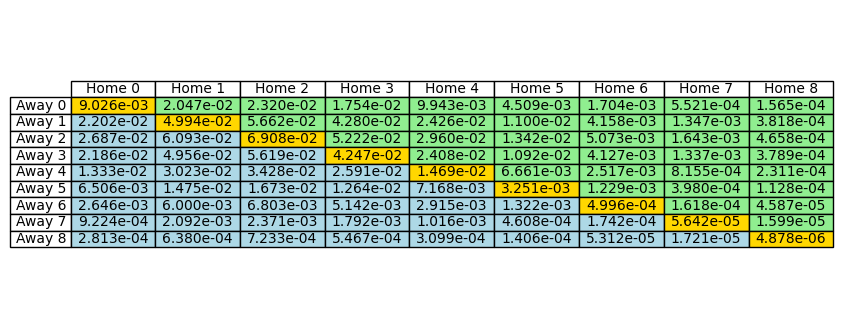

In [ ]:
import matplotlib.pyplot as plt

data = exact_score_prob
rows = [f"Away {i}" for i in range(0, data.shape[0])]
columns = [f"Home {i}" for i in range(0, data.shape[1])]

formatted_data = [[f"{val:.3e}" for val in row] for row in data]

fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=formatted_data,
    rowLabels=rows,
    colLabels=columns,
    cellLoc="center",
    loc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(data.shape[1])))

for (row, col), cell in table.get_celld().items():
    if row == 0:
        continue
    if row - 1 == col:
        cell.set_facecolor("#FFD700")  # Gold
    elif row - 1 > col - 1 and col >= 0:  # Lower triangle
        cell.set_facecolor("#ADD8E6")  # Light blue
    elif row - 1 < col:  # Upper triangle
        cell.set_facecolor("#90EE90")  # Light green

plt.show()

In [ ]:
thresholds = [0.5, 1.5, 2.5, 3.]
sums = []

for t in thresholds:
    mask = np.add.outer(
        np.arange(
            exact_score_prob.shape[0]
        ),
        np.arange(
            exact_score_prob.shape[1]
        )
    ) <= t
    # print(mask)
    sums.append(exact_score_prob[mask].sum())

print(sums)
df = pd.DataFrame({
    "Goals": thresholds,
    "Prob": sums
})
df["Implied Odds"] = 1 / df["Prob"]
print("~  ~ under market ~  ~\n", f"{home_side} v. {away_side}\n", df)

[np.float64(0.009025691352710601), np.float64(0.051515759586165305), np.float64(0.15153058548321066), np.float64(0.30847652312769186)]
~  ~ under market ~  ~
 West Ham v. Wolverhampton Wanderers
    Goals      Prob  Implied Odds
0    0.5  0.009026    110.794837
1    1.5  0.051516     19.411536
2    2.5  0.151531      6.599328
3    3.0  0.308477      3.241738


Now we do it with the over

In [ ]:
thresholds = [0.5, 1.5, 2.5, 3., 3.5]
sums = []

for t in thresholds:
    mask = np.add.outer(
        np.arange(
            exact_score_prob.shape[0]
        ),
        np.arange(
            exact_score_prob.shape[1]
        )
    ) >= t
    # print(mask)
    sums.append(exact_score_prob[mask].sum())

print(sums)
df = pd.DataFrame({
    "Goals": thresholds,
    "Prob": sums
})

df["Implied Odds"] = 1 / df["Prob"]
print("~  ~ over market ~  ~\n", f"{home_side} v. {away_side}\n", df)

[np.float64(0.9894278844881763), np.float64(0.9469378162547216), np.float64(0.8469229903576764), np.float64(0.8469229903576764), np.float64(0.6899770527131951)]
~  ~ over market ~  ~
 West Ham v. Wolverhampton Wanderers
    Goals      Prob  Implied Odds
0    0.5  0.989428      1.010685
1    1.5  0.946938      1.056036
2    2.5  0.846923      1.180745
3    3.0  0.846923      1.180745
4    3.5  0.689977      1.449324
